In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

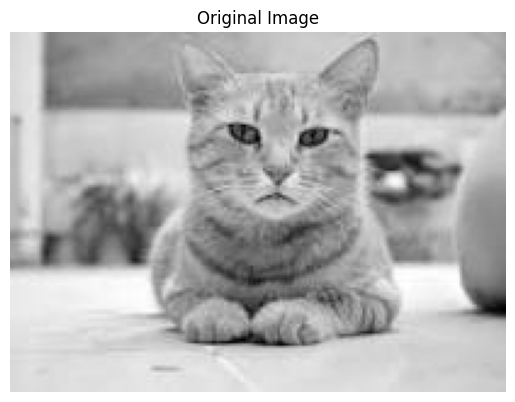

In [14]:
img = cv2.imread(cv2.samples.findFile('cat.jpeg'), cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

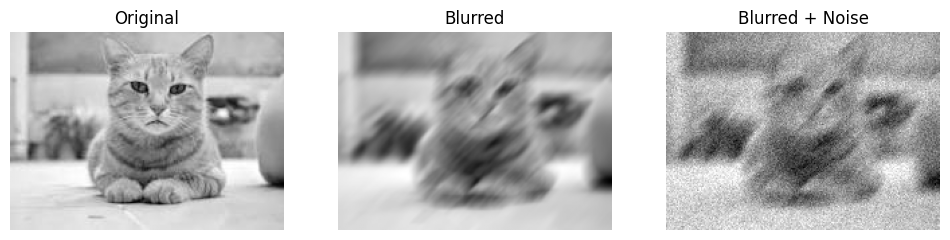

In [15]:
def motion_blur_kernel(size=15, angle=0):
    kernel = np.zeros((size, size))
    kernel[size//2, :] = 1.0
    kernel = kernel / size

    M = cv2.getRotationMatrix2D((size/2, size/2), angle, 1)
    rotated_kernel = cv2.warpAffine(kernel, M, (size, size))
    return rotated_kernel

kernel = motion_blur_kernel(size=15, angle=45)


blurred = cv2.filter2D(img.astype(np.float32), -1, kernel)


noise_sigma = 15
noise = np.random.normal(0, noise_sigma, img.shape).astype(np.float32)
noisy_blurred = blurred + noise
noisy_blurred = np.clip(noisy_blurred, 0, 255)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(blurred, cmap='gray')
plt.title('Blurred')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(noisy_blurred, cmap='gray')
plt.title('Blurred + Noise')
plt.axis('off')

plt.show()


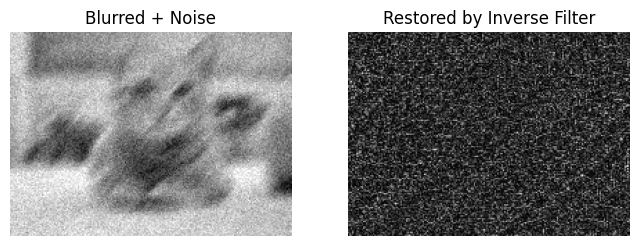

In [16]:
def inverse_filter(degraded, kernel, eps=1e-3):

    G = np.fft.fft2(degraded)
    H = np.fft.fft2(kernel, s=degraded.shape)


    H_mag = np.abs(H)
    H = np.where(H_mag < eps, eps, H)


    F_hat = G / H


    f_hat = np.abs(np.fft.ifft2(F_hat))

    return f_hat


restored_inverse = inverse_filter(noisy_blurred, kernel)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(noisy_blurred, cmap='gray')
plt.title('Blurred + Noise')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(restored_inverse, cmap='gray')
plt.title('Restored by Inverse Filter')
plt.axis('off')
plt.show()


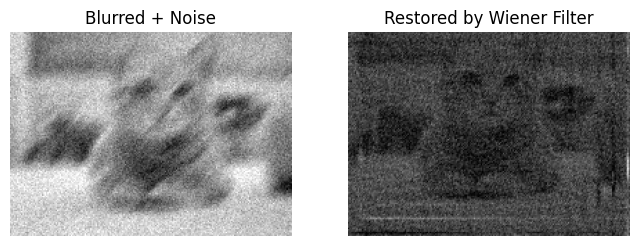

In [17]:
def wiener_filter(degraded, kernel, K=0.01):
    G = np.fft.fft2(degraded)
    H = np.fft.fft2(kernel, s=degraded.shape)
    H_conj = np.conj(H)

    denominator = (np.abs(H)**2) + K
    F_hat = (H_conj / denominator) * G
    f_hat = np.abs(np.fft.ifft2(F_hat))
    return f_hat

restored_wiener = wiener_filter(noisy_blurred, kernel, K=0.01)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(noisy_blurred, cmap='gray')
plt.title('Blurred + Noise')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(restored_wiener, cmap='gray')
plt.title('Restored by Wiener Filter')
plt.axis('off')
plt.show()


In [18]:
import kagglehub, os, cv2
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift

In [19]:
import kagglehub

path = kagglehub.dataset_download("paultimothymooney/sample-images-for-kaggle-demos")

print("Path to dataset files:", path)

image_files = [os.path.join(path, f) for f in os.listdir(path) if f.lower().endswith(('.jpg','.png','.jpeg'))]
print("Found", len(image_files), "images")

100%|██████████| 1.07M/1.07M [00:00<00:00, 93.9MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/sample-images-for-kaggle-demos/versions/5
Found 8 images


In [20]:
def load_image_gray(fname, size=256):
    img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (size, size))
    return img.astype(np.float32)/255.0

images = [load_image_gray(f) for f in image_files[:9]]

In [21]:
def motion_blur_psf(length, angle_deg, size):
    psf = np.zeros((size,size))
    angle = np.deg2rad(angle_deg)
    cx, cy = size//2, size//2
    dx, dy = np.cos(angle), np.sin(angle)
    for i in range(length):
        x = int(round(cx + (i - length//2) * dx))
        y = int(round(cy + (i - length//2) * dy))
        if 0 <= x < size and 0 <= y < size:
            psf[y,x] = 1
    psf /= psf.sum()
    return psf

In [22]:
def degrade_image(img, psf, noise_sigma=0.01):
    H = fft2(ifftshift(psf))
    G = fft2(img) * H
    g = np.real(ifft2(G))
    g_noisy = g + np.random.normal(0, noise_sigma, img.shape)
    return np.clip(g_noisy,0,1), H

In [23]:
def inverse_filter(G, H, eps=1e-3):
    H_mod = H.copy()
    H_mod[np.abs(H_mod) < eps] = eps
    F_hat = G / H_mod
    return np.real(ifft2(F_hat))

def wiener_filter(G, H, K):
    H_conj = np.conj(H)
    denom = (np.abs(H)**2 + K)
    F_hat = (H_conj / denom) * G
    return np.real(ifft2(F_hat))

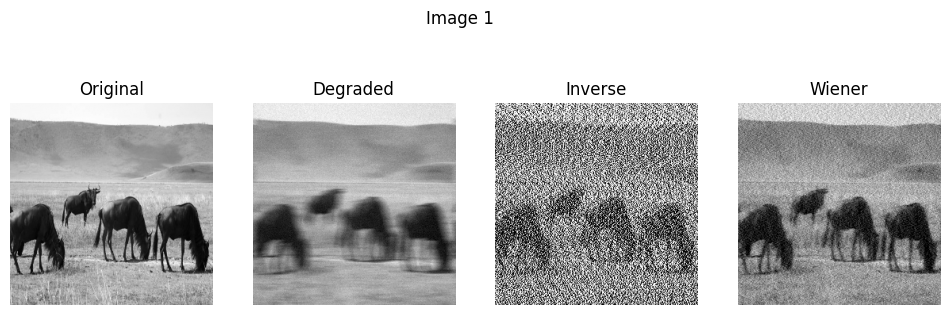

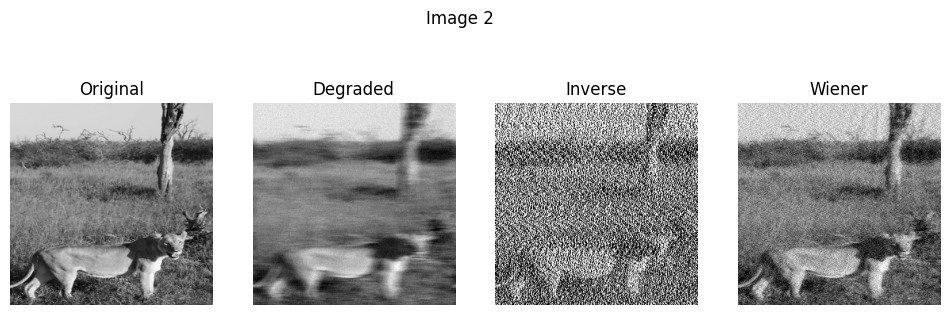

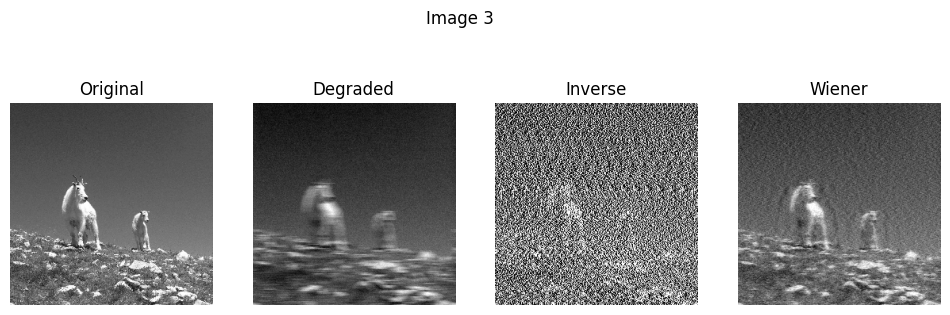

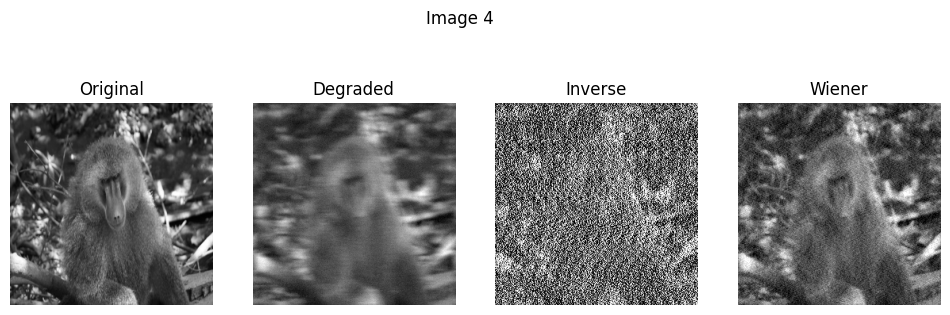

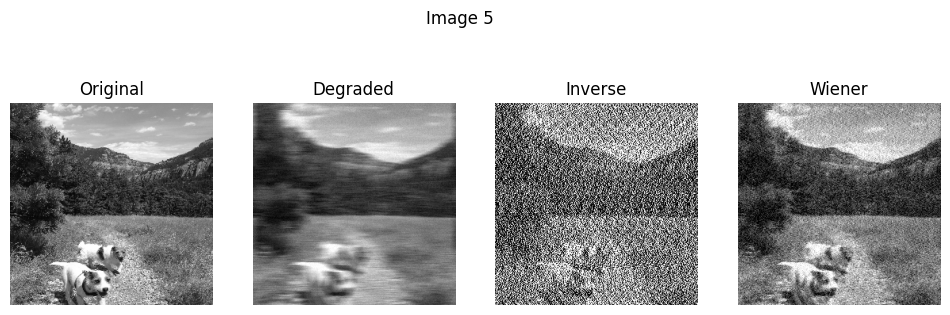

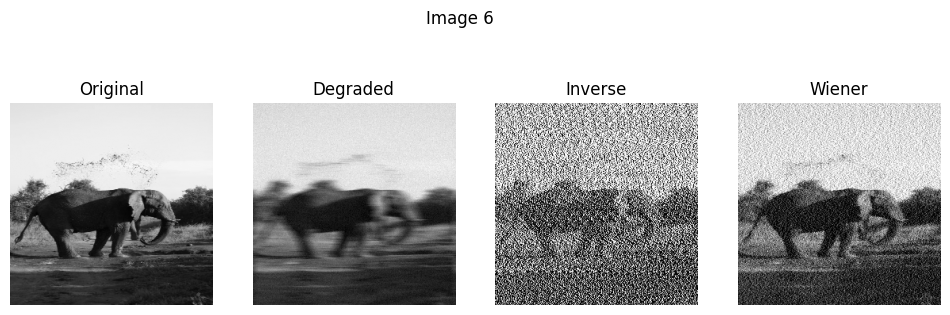

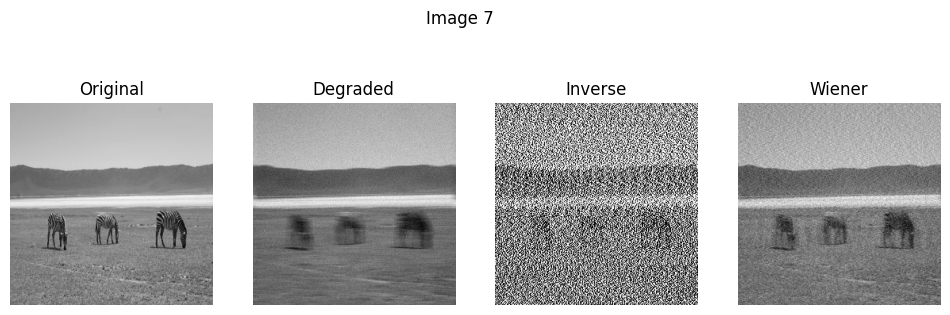

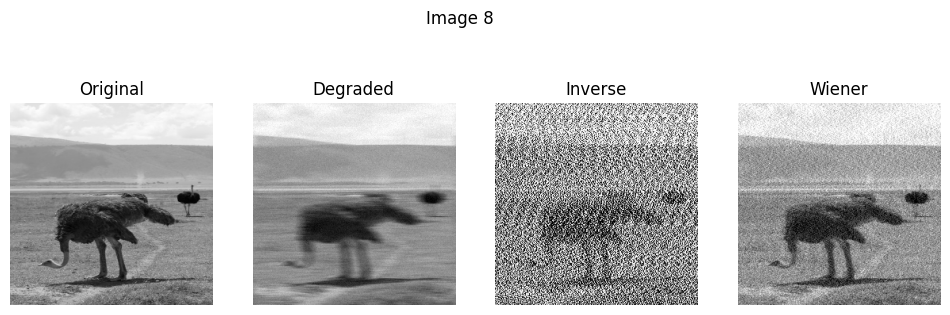

In [24]:
psf = motion_blur_psf(length=15, angle_deg=0, size=256)
noise_sigma = 0.02

for idx, img in enumerate(images):
    degraded, H = degrade_image(img, psf, noise_sigma=noise_sigma)
    G = fft2(degraded)


    signal_var = np.var(img)
    noise_var = noise_sigma**2
    K = noise_var / (signal_var + 1e-12)

    inv_res = inverse_filter(G, H, eps=1e-2)
    wiener_res = wiener_filter(G, H, K)


    plt.figure(figsize=(12,4))
    plt.subplot(1,4,1); plt.imshow(img, cmap='gray'); plt.title("Original"); plt.axis("off")
    plt.subplot(1,4,2); plt.imshow(degraded, cmap='gray'); plt.title("Degraded"); plt.axis("off")
    plt.subplot(1,4,3); plt.imshow(np.clip(inv_res,0,1), cmap='gray'); plt.title("Inverse"); plt.axis("off")
    plt.subplot(1,4,4); plt.imshow(np.clip(wiener_res,0,1), cmap='gray'); plt.title("Wiener"); plt.axis("off")
    plt.suptitle(f"Image {idx+1}")
    plt.show()